In [1]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Note: using Google CoLab


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# HIDE OUTPUT
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (166/166), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 212 (delta 101), reused 96 (delta 96), pack-reused 46 (from 1)
Receiving objects: 100% (212/212), 4.16 MiB | 17.68 MiB/s, done.
Resolving deltas: 100% (107/107), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 27.4 MB/s eta 0:00:00


In [4]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import torch
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import legacy
import time

In [7]:
MODEL_PATH = "/content/drive/My Drive/MA/model/network-snapshot-005000.pkl"

In [8]:
print(f'Loading networks from" {MODEL_PATH}"...' )
device = torch.device('cuda')

with open(MODEL_PATH, 'rb') as f:
    G = legacy.load_network_pkl(f)['G_ema']\
      .requires_grad_(False).to(device)

Loading networks from" /content/drive/My Drive/MA/model/network-snapshot-005000.pkl"...


In [9]:
# Generate a random latent vector
z = torch.randn([1, G.z_dim], device=device)  # device is your device (e.g., 'cuda')

# Generate an image
img = G(z, None, truncation_psi=0.7, noise_mode='const')  # Adjust truncation_psi as needed

# Display the image
img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').show()

Setting up PyTorch plugin "bias_act_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.
Setting up PyTorch plugin "filtered_lrelu_plugin"... 

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


Done.


In [10]:
num_samples = 1000  # Number of latent vectors to generate
latent_vectors = []

for _ in range(num_samples):
    z = torch.randn([1, G.z_dim], device=device)
    latent_vectors.append(z.cpu().numpy().flatten())  # Store as flattened NumPy array

latent_vectors = np.array(latent_vectors)  # Convert to NumPy array

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
principal_components = pca.fit_transform(latent_vectors)

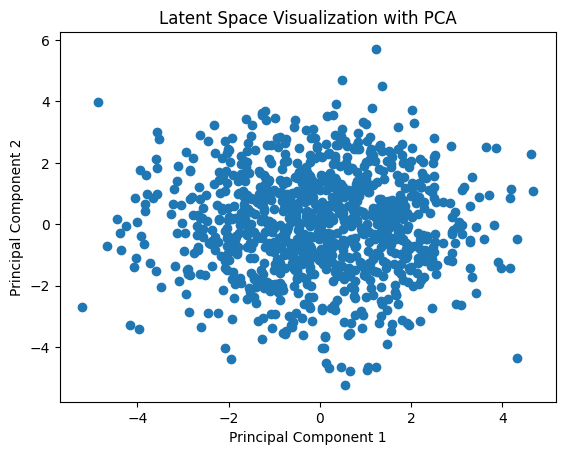

In [36]:
import matplotlib.pyplot as plt

plt.scatter(principal_components[:, 0], principal_components[:, 1])
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Latent Space Visualization with PCA")
plt.show()

In [48]:
import numpy as np

# Range/Density of the grid
x_range = np.linspace(-67, 3, 12)
y_range = np.linspace(-67, 3, 12)

# Coordinates
grid_x, grid_y = np.meshgrid(x_range, y_range)
grid_points = np.stack((grid_x.flatten(), grid_y.flatten()), axis=1)

In [49]:
from PIL import Image

images = []
for point in grid_points:

    latent_vector = pca.inverse_transform(point.reshape(1, -1))

    # Generate an image from the latent vector
    latent_vector = torch.tensor(latent_vector, device=device).float()
    img = G(latent_vector, None, truncation_psi=0.7, noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    images.append(PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB'))

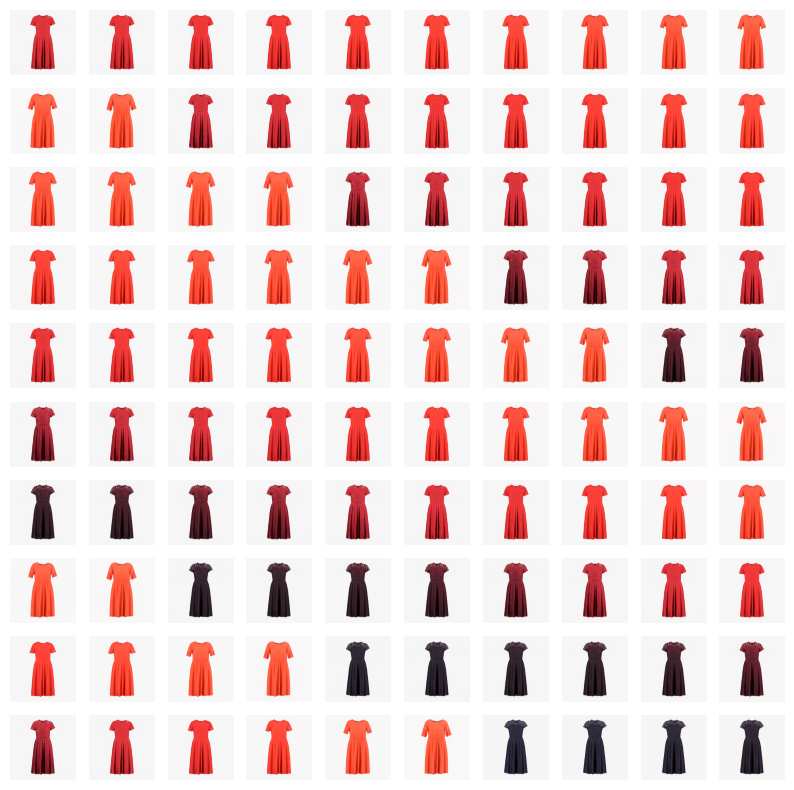

In [50]:
import matplotlib.pyplot as plt

# Create a figure and axes
fig, axes = plt.subplots(10, 10, figsize=(10, 10))

# Plot the images on the grid
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.axis('off')  # Turn off axis labels

plt.show()

In [51]:
!pip install plotly

In [65]:

import plotly.graph_objects as go
import numpy as np
import io
import base64
from PIL import Image

# Function to convert PIL Image to base64 string (unchanged)
def pil_image_to_base64(image):
    buffered = io.BytesIO()
    image.save(buffered, format="PNG")
    encoded_image = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return encoded_image

# Assuming G.z_dim is 3 (or whatever the actual dimension is)
num_latent_dims = G.z_dim

# Generate a 3D grid of points in the latent space
x_range = np.linspace(-3, 3, 10)  # Adjust range as needed
y_range = np.linspace(-3, 3, 10)  # Adjust range as needed
z_range = np.linspace(-3, 3, 10)  # Adjust range as needed

grid_x, grid_y, grid_z = np.meshgrid(x_range, y_range, z_range)
grid_points = np.stack((grid_x.flatten(), grid_y.flatten(), grid_z.flatten()), axis=1)

# ------------------------------- KEY CHANGES -------------------------------
# Project the 3D grid to the latent space using PCA if needed
if num_latent_dims > 3:  # Only apply PCA if latent space is more than 3 dimensions
    # Perform PCA to reduce to 3 dimensions
    pca3d = PCA(n_components=3)
    grid_points_pca = pca3d.fit_transform(grid_points)
else:
    grid_points_pca = grid_points
# ----------------------------------------------------------------------------


# Generate images for each point in the grid
images = []
for point in grid_points_pca:  # Use grid_points_pca here

    # Reshape the point to (1, num_latent_dims) and convert to tensor
    latent_vector = torch.tensor(point.reshape(1, -1), device=device).float()

    # Generate an image from the latent vector
    img = G(latent_vector, None, truncation_psi=0.7, noise_mode='const')
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    image = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
    images.append(image)


# Create a Plotly 3D scatter plot with images (unchanged)
# ... (rest of the code for creating the Plotly plot)

AssertionError: Wrong size for dimension 1: got 3, expected 512